In [61]:
import numpy as np
import pandas as pd

# Goal: 
# Predict name of the probiotic (genus level) based on the detailed effect free text column
# Create category id column which you actually predics 
# Not on species level, rather on genus, so combine classes based on the first word in the Name column
df = pd.read_excel(r"Probioticsdata.xlsx")
df
nimet = df[['Name']]

#nimet.shape, tästä koko
genus = [None] * 917

for i in range(917):
    nimi = nimet.Name[i]
    nimi = nimi.split(" ")
    genus[i] = nimi[0]

df['Strain'] = pd.Series(genus, index=df.index) # replacee strain columni genus datal, rename, parsi dataa
df = df[['Name','Strain','Detailed Effect']]
df.columns = ['Name', 'Genus', 'Detailed Effect']
df.head()

,Name,Genus,Detailed Effect
0,Acinetobacter calcoaceticus,Acinetobacter,Maintains Healthy GI-Tract MicroFloral Ecologi...
1,Akkermansia muciniphila,Akkermansia,[1] Treating Metabolic Disorders. [2] is a muc...
2,Arthrobacter citreus,Arthrobacter,Maintains Healthy GI-Tract MicroFloral Ecologi...
3,Arthrobacter globiformis,Arthrobacter,Maintains Healthy GI-Tract MicroFloral Ecologi...
4,Arthrobacter luteus,Arthrobacter,Maintains Healthy GI-Tract MicroFloral Ecologi...


In [62]:
# Add genus IDs which you actually try to predict

from io import StringIO

col = ['Genus', 'Detailed Effect']
df = df[col]
df = df[pd.notnull(df['Detailed Effect'])]
df.columns = ['Genus', 'Detailed_Effect']
df['genus_id'] = df['Genus'].factorize()[0]
species_id_df = df[['Genus', 'genus_id']].drop_duplicates().sort_values('genus_id')
specis_to_id = dict(species_id_df.values)
id_to_species = dict(species_id_df[['genus_id', 'Genus']].values)
df.head()


# In total 38 different genuses :) better for predicting, more data per genus


,Genus,Detailed_Effect,genus_id
0,Acinetobacter,Maintains Healthy GI-Tract MicroFloral Ecologi...,0
1,Akkermansia,[1] Treating Metabolic Disorders. [2] is a muc...,1
2,Arthrobacter,Maintains Healthy GI-Tract MicroFloral Ecologi...,2
3,Arthrobacter,Maintains Healthy GI-Tract MicroFloral Ecologi...,2
4,Arthrobacter,Maintains Healthy GI-Tract MicroFloral Ecologi...,2


In [43]:
# Extract X key words from the free text field, using rake-nltk
#!/usr/bin/env python



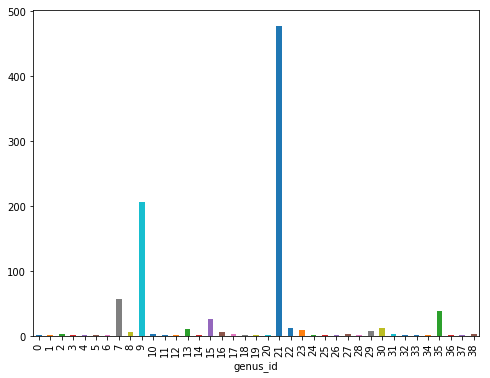

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('genus_id').Detailed_Effect.count().plot.bar(ylim=0)
plt.show()

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Detailed_Effect).toarray()
labels = df.genus_id
features.shape

(917, 303)

In [54]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for genus, genus_id in sorted(specis_to_id.items()):
  features_chi2 = chi2(features, labels == genus_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print(genus)
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

Acinetobacter
  . Most correlated unigrams:
. microfloral
. normal
  . Most correlated bigrams:
. microfloral ecologies
. gut immune
Akkermansia
  . Most correlated unigrams:
. body
. disorders
  . Most correlated bigrams:
. available soon
. info available
Arthrobacter
  . Most correlated unigrams:
. microfloral
. normal
  . Most correlated bigrams:
. microfloral ecologies
. gut immune
Atopobium
  . Most correlated unigrams:
. time
. effects
  . Most correlated bigrams:
. available soon
. info available
Azomonas
  . Most correlated unigrams:
. microfloral
. normal
  . Most correlated bigrams:
. microfloral ecologies
. gut immune
Azospirillum
  . Most correlated unigrams:
. microfloral
. normal
  . Most correlated bigrams:
. microfloral ecologies
. gut immune
Azotobacter
  . Most correlated unigrams:
. microfloral
. normal
  . Most correlated bigrams:
. microfloral ecologies
. gut immune
Bacillus
  . Most correlated unigrams:
. protective
. bacillus
  . Most correlated bigrams:
. suppor

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


X_train, X_test, y_train, y_test = train_test_split(df['Detailed_Effect'], df['genus_id'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)



In [66]:
# Very imbalanced classes , use SMOTE , install:
# TRY : pip install -U imbalanced-learn
# OR: conda install -c glemaitre imbalanced-learn
# and then from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

SyntaxError: invalid syntax (<ipython-input-66-cdcd732f1765>, line 2)

In [57]:
print(clf.predict(count_vect.transform(["immune"])))
print(clf.predict(count_vect.transform(["microfloral"])))
print(clf.predict(count_vect.transform(["info available"])))
print(clf.predict(count_vect.transform(["treatment"])))
print(clf.predict(count_vect.transform(["disorders"])))
print(clf.predict(count_vect.transform(["info available"])))

[21]
[21]
[21]
[21]
[21]
[21]


In [19]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting']


In [27]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
type(twenty_train)

sklearn.utils.Bunch

In [28]:
twenty_train.target_names #prints all the categories
print("\n".join(twenty_train.data[0].split("\n")[:3])) #prints first line of the first data file

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu


In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(645, 5854)

In [30]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

ValueError: Found input variables with inconsistent numbers of samples: [645, 11314]

In [31]:
>>> from sklearn.pipeline import Pipeline
>>> text_clf = Pipeline([('vect', CountVectorizer()),
...                      ('tfidf', TfidfTransformer()),
...                      ('clf', MultinomialNB()),
... ])
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

In [33]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
predicted = text_clf.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.7738980350504514

In [91]:
>>> from sklearn.linear_model import SGDClassifier
>>> text_clf_svm = Pipeline([('vect', CountVectorizer()),
...                      ('tfidf', TfidfTransformer()),
...                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
...                                            alpha=1e-3, n_iter=5, random_state=42)),
... ])
>>> _ = text_clf_svm.fit(twenty_train.data, twenty_train.target)
>>> predicted_svm = text_clf_svm.predict(twenty_test.data)
>>> np.mean(predicted_svm == twenty_test.target)

C:\Users\ilona.l.lehtinen\AppData\Local\Continuum\anaconda32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.8238183749336165

In [92]:
>>> from sklearn.model_selection import GridSearchCV
>>> parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
...               'tfidf__use_idf': (True, False),
...               'clf__alpha': (1e-2, 1e-3),
... }